# Cancer Detection using CNN

### Problem Description
In this project, I will develop a convolutional neural network (CNN) to detect metastatic cancer in small image patches from larger digital pathology scans. The dataset, available on Kaggle (https://www.kaggle.com/c/histopathologic-cancer-detection/data), consists of numerous small pathology images. The objective is to classify each image based on whether the central 32x32 pixel region contains tumor tissue, ignoring tumor presence in the surrounding area. A positive label indicates the presence of at least one pixel of tumor tissue in the central region.

In [109]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D

### Exploratory Data Analysis
Our dataset comprises 220,025 training images, each with a resolution of 96x96 pixels. Each image is binary-labeled, indicating the presence (1) or absence (0) of tumor tissue. The distribution of labels shows a relatively balanced dataset, with 130,908 images labeled as 0 (no tumor) and 89,117 labeled as 1 (tumor), approximating a 60/40 split

In [110]:
train_labels = pd.read_csv('data/train_labels.csv', index_col='id')['label']
print(train_labels.head())

id
f38a6374c348f90b587e046aac6079959adf3835    0
c18f2d887b7ae4f6742ee445113fa1aef383ed77    1
755db6279dae599ebb4d39a9123cce439965282d    0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08    0
068aba587a4950175d04c680d38943fd488d6a9d    0
Name: label, dtype: int64


In [111]:
train_images = os.listdir('data/train/')
print(train_images[:3])

['f0c2a0b8ef3024f407fa97d852d49be0215cafe0.tif', '99ef485f205645918613cd04281098daa7c17819.tif', 'e2612e173abd0e8bb54a3c3db3f264b63d80bffb.tif']


In [112]:
print("Total number of train images:", len(train_images), '\n')

Total number of train images: 220025 



Let's visualize some train images

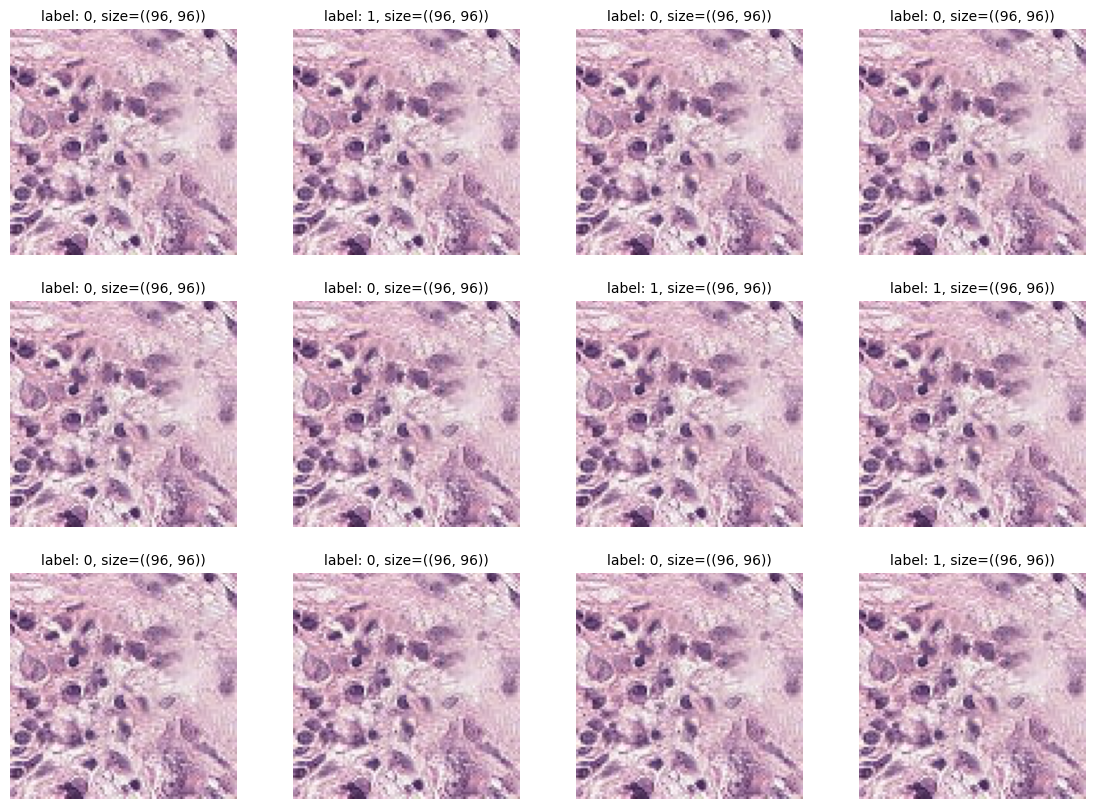

In [113]:
fig, axs = plt.subplots(3, 4, figsize=(14, 10))
for idx, (h, v) in enumerate([(i, j) for i in range(3) for j in range(4)]):
    image = Image.open('data/train/' + Id + '.tif')
    axs[h, v].imshow(image)
    axs[h, v].axis('off')
    axs[h, v].set_title(f"label: {train_labels.iloc[idx]}, size=({image.size})", fontsize=10)
plt.show()

Let's look at the distribution of labels in the training data

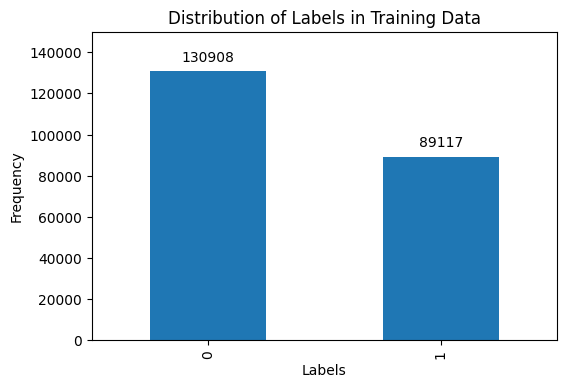

In [114]:
plt.figure(figsize=(6, 4)) 
ax = train_labels.value_counts().plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in Training Data')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.ylim(0, 150000)
plt.show()

### Model Building and Training
The model employs a streamlined sequential architecture for binary classification, utilizing two convolutional blocks. Each block features a set of convolutional layers with 32 and 64 filters respectively, employing a 3×3 kernel size, followed by ReLU activation. Max pooling is used after each convolutional layer to reduce spatial dimensions, and dropout is incorporated to combat overfitting, with rates of 0.25 after each convolutional block. The architecture culminates with a global average pooling layer leading into a dense layer of 256 units with ReLU activation, followed by a dropout rate of 0.50 to further ensure generalization. The output is a single unit with a sigmoid activation function to predict the presence of tumor tissue.

In [134]:
def load_data(train_images, train_labels):

    N = len(train_images)
    X = np.zeros((N, 96, 96, 3), dtype=np.uint8)
    y = np.zeros((N,), dtype=int)

    for i, train_image in enumerate(train_images):

        train_image_path = os.path.join('data/train/', train_image)
        
        image = Image.open(train_image_path)
        image = image.resize((96, 96)) 
        X[i] = image
        
        train_image_id = train_image.split('.')[0]
        label = train_labels.loc[train_image_id]
        y[i] = label
    
    return X, y

In [135]:
X, y = load_data(train_images, train_labels)

In [140]:
# Parameters
kernel_size = (3,3)
pool_size = (2,2)
filters_1st_conv_block = 32
filters_2nd_conv_block = 64
dropout_conv = 0.25
dropout_dense = 0.50

# Initializing the model
model = Sequential()

# Input layer
model.add(Input(shape=(96, 96, 3)))

# First conv block
model.add(Conv2D(filters_1st_conv_block, kernel_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size)) 
model.add(Dropout(dropout_conv))

# Second conv block
model.add(Conv2D(filters_2nd_conv_block, kernel_size, activation='relu'))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# Dense layer
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_dense))

# Output layer
model.add(Dense(1, activation="sigmoid"))

# Summarize the model
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,289 (141.75 KB)

 Trainable params: 36,289 (141.75 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])

Let's split the dataset into train and validation and train the CNN model

In [142]:
X_train, X_val, y_train, y_val = train_test_split(X[:], y[:], test_size=0.3, random_state=42)

In [143]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 271s 56ms/step - accuracy: 0.7648 - loss: 0.7468 - val_accuracy: 0.8018 - val_loss: 0.4368
Epoch 2/10
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 272s 56ms/step - accuracy: 0.8156 - loss: 0.4193 - val_accuracy: 0.8382 - val_loss: 0.3710
Epoch 3/10
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 276s 57ms/step - accuracy: 0.8397 - loss: 0.3722 - val_accuracy: 0.8608 - val_loss: 0.3307
Epoch 4/10
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 268s 56ms/step - accuracy: 0.8521 - loss: 0.3460 - val_accuracy: 0.8652 - val_loss: 0.3323
Epoch 5/10
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 260s 54ms/step - accuracy: 0.8623 - loss: 0.3276 - val_accuracy: 0.8652 - val_loss: 0.3057
Epoch 6/10
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 266s 55ms/step - accuracy: 0.8675 - loss: 0.3155 - val_accuracy: 0.8766 - val_loss: 0.2991
Epoch 7/10
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 510s 106ms/step - accuracy: 0.8758 - loss: 0.3009 - val_accuracy: 0.8658 - val_loss: 0.3085
Epoch 8/10
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 272s 57ms/step - accuracy:

### Results
The model was trained over 10 epochs, during which both the training and validation accuracies improved from approximately 80% to about 90%. Extending the training for additional epochs may further enhance performance.

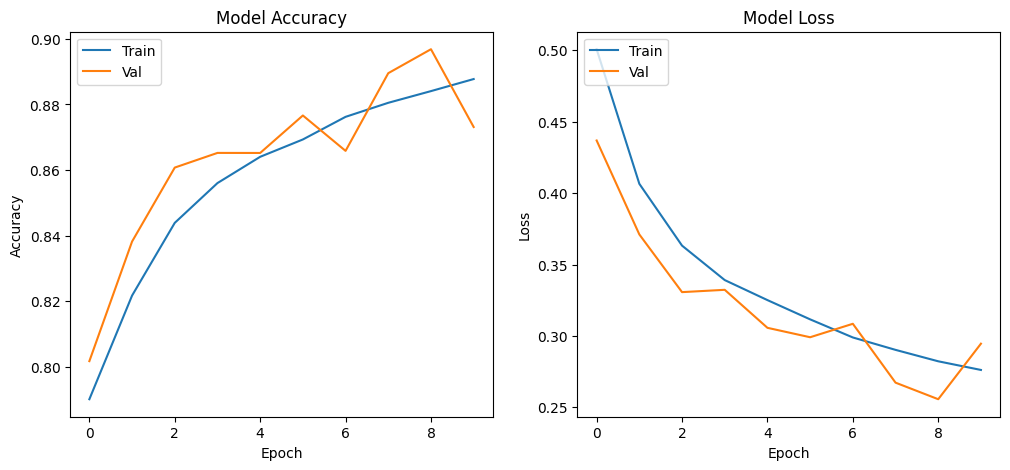

In [144]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

### Kaggle Submission

In [145]:
test_path = 'data/test/'
test_images = os.listdir(test_path)

N = len(test_images)

X_test = np.zeros((N, 96, 96, 3), dtype=np.uint8)
X_test_ids = []
for i, test_image in enumerate(test_images):
    test_image_path = os.path.join(test_path, test_image)
    image = Image.open(test_image_path)
    X_test[i] = image.resize((96, 96)) 
    X_test_ids.append(test_image.split('.')[0])

predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

In [147]:
submission_df = pd.DataFrame({
    'id': X_test_ids,
    'label': predicted_labels.flatten()
})

submission_df.to_csv('submission.csv', index=False)

### Conclusion
This project successfully demonstrated the effectiveness of a convolutional neural network in identifying metastatic cancer from small pathology image patches. The model achieved substantial improvement in accuracy over the course of training, reaching close to 90%. Future work could explore extending the training period, adjusting model parameters, or incorporating more sophisticated data augmentation to further enhance the model's accuracy and generalizability.